In [1]:
import tensorflow as tf
import string
import requests
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
response = requests.get('https://www.gutenberg.org/files/61262/61262-0.txt')

In [3]:
data = response.text.replace('\r', '').replace('\ufeff', '')
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
new_data = data.translate(translator)
new_data = new_data.replace('”', '').replace('“', '')
processeddata = new_data.split('\n')

In [4]:
processeddata = [x.encode('ascii', 'ignore').decode('ascii') for x in processeddata]
processeddata = processeddata[112:]

In [5]:
processeddata[0]

'I was standing at the window of Poirots rooms looking out idly on'

In [6]:
len(processeddata)

7863

In [7]:
processeddata = " ".join(processeddata)
tokens = processeddata.split()
tokens = [word.lower() for word in tokens]

In [8]:
print(tokens[:50])

['i', 'was', 'standing', 'at', 'the', 'window', 'of', 'poirots', 'rooms', 'looking', 'out', 'idly', 'on', 'the', 'street', 'below', 'thats', 'queer', 'i', 'ejaculated', 'suddenly', 'beneath', 'my', 'breath', 'what', 'is', 'mon', 'ami', 'asked', 'poirot', 'placidly', 'from', 'the', 'depths', 'of', 'his', 'comfortable', 'chair', 'deduce', 'poirot', 'from', 'the', 'following', 'facts', 'here', 'is', 'a', 'young', 'lady', 'richly']


In [9]:
length = 50 + 1
lines = []
for i in range(length, len(tokens)):
    seq = tokens[i-length:i]
    line = ' '.join(seq)
    lines.append(line)

print(len(lines))

55843


In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

In [11]:
sequences = np.array(sequences)
X, y = sequences[:, :-1], sequences[:, -1]

In [12]:
vocabsize = len(tokenizer.word_index) + 1

In [13]:
y = tf.keras.utils.to_categorical(y, num_classes=vocabsize)

In [14]:
seq_length = X.shape[1]

In [15]:
lstmmodel = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocabsize, 50, input_length = seq_length),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(vocabsize, activation='softmax')
])
lstmmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            325050    
                                                                 
 lstm (LSTM)                 (None, 50, 100)           60400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 6501)              656601    
                                                                 
Total params: 1,132,551
Trainable params: 1,132,551
Non-trainable params: 0
_________________________________________________________________


In [16]:
lstmmodel.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
checkpoint = ModelCheckpoint(filepath="./modelsnlp/nlpbestmodel1.h5", monitor = 'accuracy', verbose=2, save_best_only=True)
earlystopping = EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 40,  restore_best_weights = True)

In [17]:
history = lstmmodel.fit(X, y, epochs = 1, callbacks=[checkpoint, earlystopping])

1746/1746 [==============================] - ETA: 0s - loss: 6.7080 - accuracy: 0.0582
Epoch 00001: accuracy improved from -inf to 0.05816, saving model to ./modelsnlp/nlpbestmodel1.h5
1746/1746 [==============================] - 69s 13ms/step - loss: 6.7080 - accuracy: 0.0582


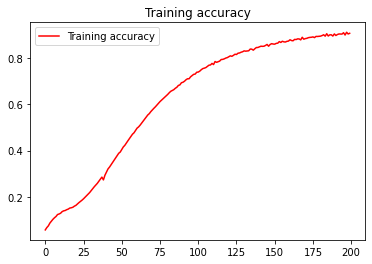

<Figure size 432x288 with 0 Axes>

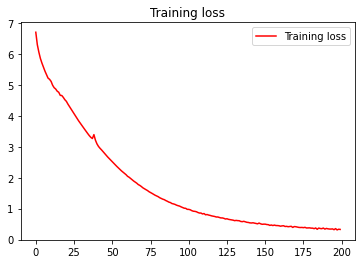

<Figure size 432x288 with 0 Axes>

In [18]:
accuracy = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'red', label='Training accuracy')
plt.title('Training accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'red', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [18]:
weightfile = './modelsnlp/nlpbestmodel.h5'
lstmmodel.load_weights(weightfile)
print("Weight loaded successfully")

Weight loaded successfully


In [19]:
lines[100]

'so what drama is this being played is the girl a crook and are the shadowers detectives preparing to arrest her or are they the scoundrels and are they plotting to attack an innocent victim what does the great detective say the great detective mon ami chooses as ever the simplest'

In [20]:
seed_text = 'so the words are'

In [21]:
def generate_text_seq(lstmmodel, tokenizer, text_seq_length, seed_text, n_words):
    text = []
    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([seed_text])[0]
        encoded = pad_sequences([encoded], maxlen = text_seq_length, truncating = 'pre')
        predicted = lstmmodel.predict(encoded)
        predictclass = np.argmax(predicted,axis=1)
        predictword = ''
        for word, index in tokenizer.word_index.items():
            if index == predictclass:
                predictword = word
                break
        seed_text = seed_text + ' ' + predictword
        text.append(predictword)
    return ' '.join(text)


In [22]:
generate_text_seq(lstmmodel, tokenizer, seq_length, seed_text, 100)

'anyway yes though i understand its a minor official if you havent missed a gentle silence round that of some kind to argue mrs first idea most impossible you do not know what is the little man has never only stolen it questioned with some time gregory remembers that i could not make a guess in its money we followed him to death he held through the inside and romantic peace and was arranged his idea you puzzled upstairs japp not a few days the day was now as the man put down the jewel i gave your step city'